# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

Let's get the data!

In [9]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Inicializar el tokenizador
tokenizer = Tokenizer()

# Ajustar el tokenizador al corpus
tokenizer.fit_on_texts(corpus)


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [11]:
# Obtener el tamaño del vocabulario
total_words = len(tokenizer.word_index) + 1

print(f"Total de palabras en el vocabulario: {total_words}")


Total de palabras en el vocabulario: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [12]:
input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]  # Convertir la línea en una lista de tokens
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]  # Crear secuencias n-gram
        input_sequences.append(n_gram_sequence)

print(f"Ejemplo de secuencias n-gram: {input_sequences[:5]}")


Ejemplo de secuencias n-gram: [[3, 2], [3, 2, 313], [3, 2, 313, 1375], [3, 2, 313, 1375, 4], [118, 1376]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Encontrar la longitud de la secuencia más larga
max_sequence_len = max(len(seq) for seq in input_sequences)

# Aplicar padding a todas las secuencias para que tengan la misma longitud
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

print(f"Tamaño de secuencia después de padding: {input_sequences.shape}")


Tamaño de secuencia después de padding: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [14]:
import numpy as np
import tensorflow as tf

# Asegurar que input_sequences está correctamente definido
if 'input_sequences' not in locals():
    raise ValueError("Error: 'input_sequences' no está definido. Asegúrate de haber ejecutado la celda donde se genera.")

# Separar predictores (X) y etiquetas (y)
X = input_sequences[:, :-1]  # Todos los elementos excepto el último
y = input_sequences[:, -1]   # Último elemento de cada secuencia

# Verificar las formas de X e y
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")




Forma de X: (15484, 10)
Forma de y: (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [15]:
# Convertir las etiquetas a formato one-hot encoding
labels = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Verificar la forma de labels
print(f"Forma de labels después de one-hot encoding: {labels.shape}")



Forma de labels después de one-hot encoding: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Inicializar modelo secuencial
model = Sequential([

    # Capa de embeddings: convierte palabras en vectores de tamaño 100
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1),

    # Capa LSTM Bidireccional con 150 unidades
    Bidirectional(LSTM(150, return_sequences=True)),

    # Capa de dropout para prevenir overfitting
    Dropout(0.2),

    # Segunda capa LSTM con 100 unidades
    LSTM(100),

    # Capa densa intermedia con la mitad de las palabras en el vocabulario, usando ReLU
    Dense(total_words // 2, activation='relu'),

    # Capa de salida con activación softmax (probabilidad para cada palabra)
    Dense(total_words, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [17]:
from tensorflow.keras.optimizers import Adam

# Compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [18]:
# Mostrar resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [19]:
# Entrenar el modelo por 50 épocas
history = model.fit(X, labels, epochs=50, verbose=1)


Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.0213 - loss: 6.9843
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0259 - loss: 6.4521
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0282 - loss: 6.3888
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0216 - loss: 6.3016
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0287 - loss: 6.2731
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0250 - loss: 6.2460
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0288 - loss: 6.2507
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0272 - loss: 6.1931
Epoch 9/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0320 - loss: 6.1912
Epoch 10/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0274 - loss: 6.1779
Epoch 11/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0275 - loss: 6.1735
Epoch 12/50
484/484 ━━━━━━━━━━━━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

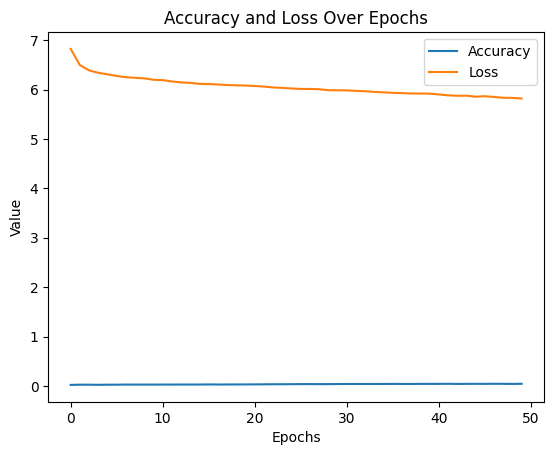

In [20]:
import matplotlib.pyplot as plt

# Graficar precisión
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.title("Accuracy and Loss Over Epochs")
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [21]:
import numpy as np

# Parámetros iniciales
seed_text = "Shall I compare thee to a summer's day"
next_words = 20  # Número de palabras a generar

for _ in range(next_words):
    # Convertir el texto semilla en secuencia de tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre'))

    # Predecir la siguiente palabra
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)

    # Obtener la palabra correspondiente del tokenizer
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    # Agregar la palabra generada al texto semilla
    seed_text += " " + output_word

# Imprimir el texto generado
print("Generated text:")
print(seed_text)


Generated text:
Shall I compare thee to a summer's day of the world of the world of the world of the world of the world of the world of the


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [22]:
seed_texts = [
    "To be or not to be",
    "O Romeo, Romeo, wherefore art thou Romeo",
    "All that glitters is not gold"
]

for seed_text in seed_texts:
    print(f"\nSeed Text: {seed_text}")

    generated_text = seed_text
    next_words = 20  # Número de palabras a generar

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre'))

        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        generated_text += " " + output_word

    print("Generated Text:")
    print(generated_text)



Seed Text: To be or not to be
Generated Text:
To be or not to be of the world of the world of the world of the world of the world of the world of the

Seed Text: O Romeo, Romeo, wherefore art thou Romeo
Generated Text:
O Romeo, Romeo, wherefore art thou Romeo love of the world of the world of the world of the world of the world of the world of

Seed Text: All that glitters is not gold
Generated Text:
All that glitters is not gold and my love of the world of the world of the world of the world of the world of the


Experiment with at least 3 different seed_text strings and see what happens!

In [23]:
def generate_text(seed_text, next_words=20):
    """
    Genera texto basado en una frase semilla utilizando el modelo entrenado.

    Parámetros:
    seed_text (str): Frase semilla para iniciar la generación de texto.
    next_words (int): Número de palabras a generar.

    Retorna:
    str: Texto generado.
    """
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre'))

        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        seed_text += " " + output_word

    return seed_text

# Probar la función con 3 frases semilla distintas
seed_phrases = [
    "Shall I compare thee to a summer's day",
    "To be or not to be",
    "O Romeo, Romeo, wherefore art thou Romeo"
]

for phrase in seed_phrases:
    print("\nSeed Text:", phrase)
    generated_text = generate_text(phrase, next_words=20)
    print("Generated Text:", generated_text)



Seed Text: Shall I compare thee to a summer's day
Generated Text: Shall I compare thee to a summer's day of the world of the world of the world of the world of the world of the world of the

Seed Text: To be or not to be
Generated Text: To be or not to be of the world of the world of the world of the world of the world of the world of the

Seed Text: O Romeo, Romeo, wherefore art thou Romeo
Generated Text: O Romeo, Romeo, wherefore art thou Romeo love of the world of the world of the world of the world of the world of the world of
